# Plant Seedlings Classification v3


This is my 3rd approach to this competition.
This time I would like to check two methods:
1. Checklist from Jeremy Howard (https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)
2. Ensemble method from this article: https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b .

## 1. Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# PATH = os.path.join('data', 'sample') + '/'
PATH = os.path.join('data') + '/'

## 2. Jeremy Howard checklist

In his 2018 fast.ai course, Jeremy Howard proposed the following method of achieving good results with image recognition using DNN:

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


This is similar to what I've accomplished in the previous notebook, however I would like to check if using explicitly this checklist gives better results.

### 2.1

These are things we want to run before each section, so each time we start with a new network.

In [2]:
size = 128

In [3]:
arch=resnet34

In [4]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [5]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

### 2.2

In [6]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 40/60 [00:01<00:00, 39.17it/s, loss=10.7]


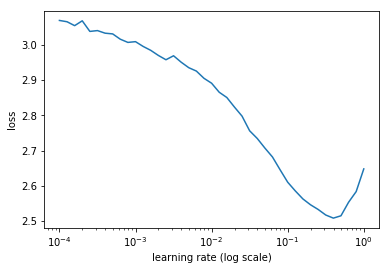

In [7]:
learn.sched.plot()

The learning rate I decide to use is 4e-2

### 2.3

In [8]:
learn.fit(4e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      1.70199 1.12725 0.61944]                         
[1.      1.36553 1.04431 0.66191]                         
[2.      1.19268 0.97679 0.67228]                         



### 2.4

In [8]:
learn.precompute=False

In [10]:
learn.fit(4e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      1.18694 0.86645 0.69524]                         
[1.      1.11817 0.82451 0.73015]                         
[2.      1.07584 0.77686 0.72937]                         



### 2.5

In [9]:
learn.unfreeze()

### 2.6

In [12]:
learning_rate_base = 4e-2
lr=np.array([learning_rate_base/9,learning_rate_base/3,learning_rate_base])
learn.learning_rate = lr

### 2.7

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 56/60 [00:12<00:00,  4.59it/s, loss=8.96]

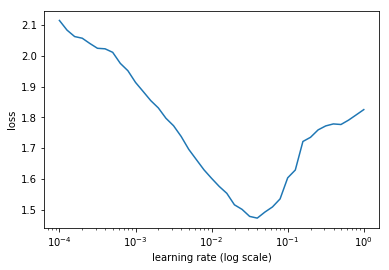

In [13]:
lrf=learn.lr_find()
learn.sched.plot()

In [14]:
learn.save('jeremy_checklist_before_training')

### 2.8

In [12]:
learn.load('jeremy_checklist_before_training')

In [13]:
learn.fit(1e-2, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[0.      0.8715  0.64988 0.77463]                          
[1.      0.58486 0.49098 0.82077]                          
[2.      0.38358 0.40444 0.86871]                          
[3.      0.34014 0.29174 0.89397]                          
[4.      0.29005 0.45881 0.85257]                          
[5.      0.21204 0.24627 0.90596]                          
[6.      0.18026 0.26315 0.90388]                          
[7.      0.20416 0.72937 0.77471]                          
[8.      0.21897 0.35922 0.87314]                          
[9.      0.18646 0.26321 0.90284]                          
[10.       0.16052  0.2483   0.91665]                      
[11.       0.13321  0.18468  0.93775]                      
[12.       0.10932  0.2003   0.93227]                      
[13.       0.10576  0.18205  0.93983]                       
[14.       0.09091  0.17566  0.94061]                       
[15.       0.11429  0.26384  0.91873]                       
[16.       0.14039  0.30942  0.9018 ]

By comparing training and validation loss, we can see that the network started overfitting about 25th epoch.

In [16]:
learn.save('jeremy_checklist_after_training')

### 2.9 -  analysing the results

In [8]:
learn.load('jeremy_checklist_after_training')

In [14]:
log_preds,y = learn.TTA()
preds = np.argmax(log_preds, axis=1)
probs = np.mean(np.exp(log_preds), axis=0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)



[[ 34   0   0   0   1   0  17   0   0   0   0   0]
 [  0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   1   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0]
 [  1   0   0   0  43   0   0   0   0   0   0   0]
 [  1   0   0   0   1  93   0   0   0   0   0   0]
 [  5   0   0   0   0   0 125   0   0   0   0   0]
 [  0   0   0   0   0   0   0  44   0   0   0   0]
 [  1   0   0   0   0   0   1   0 101   0   0   0]
 [  0   0   0   0   0   0   0   0   1  45   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   1   0   1   1   0   0   0   1   0   0  73]]


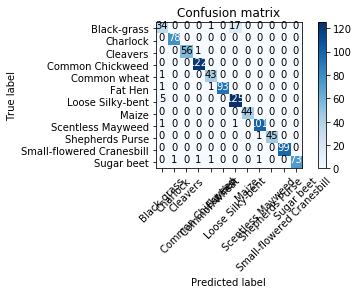

In [15]:
plot_confusion_matrix(cm, data.classes)

### 2.10 - creating submission file

In [72]:
test_log_predictions, _ = learn.TTA(is_test=True)
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
test_file_names = learn.data.test_ds.fnames

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, test_predictions_classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')

/home/paperspace/kaggle_plant_seedlings/submission_2.csv

Comparing this confusion matrix with the one from the previous notebook, it seems that it works slightly better.

On Kaggle this solution scored 0.96725, which gave me 200th place out of 580 at the time. 
However, at the 15th iteration it had higher loss than the one from the previous notebook.
I checked it and after increasing number of epochs in the previous notebook, I scored 0.97355 on Kaggle.

## 3. Ensemble method

This is method basen on the following blogpost: https://techburst.io/improving-the-way-we-work-with-learning-rate-5e99554f163b


Especially this paragraph:

It is known that a number of local minimas grows exponentially with a number of parameters. And modern deep neural nets can contain millions of them. Authors show that while most of them have similar error rates, the corresponding neural networks tend to make different mistakes. This diversity can be exploited through ensembling — training several neural network with different initialization. It is not surprising that they will converge to different solutions. Averaging over predictions from these model leads to drastic reductions in error rates.


Gao Huang and Yixuan Li were able to get an ensemble of nets at a cost of training a single neural network. They did that by exploiting the fact that at the end of each cycle(at least later ones) neural network can converge to some local minima or be close to it. When ‘restarting’ model will most likely jump over and start converging to the other optima. Gao Huang and Yixuan Li trained their models with SGDR and saved weights after each cycle. They then added M networks to their ensemble based on last M cycles. Their research showed that local minimas, to which model converged, are diverse enough to not overlap on misclassification examples. Using this method resulted in improving error rates even more on state of the art models.


### 3.1 Setup

In [51]:
size = 128

In [52]:
arch=resnet34

In [53]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)

In [54]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [55]:
learn.unfreeze()

In [56]:
# We can use the pre-trained network from the previous point as a starting point
learn.load('jeremy_checklist_before_training')

## 3.2 Training

Since we want to save the networks after each cycle, I decided to implement cycles by hand. 

In [57]:
learn.fit(1e-2, 1, cycle_len=1)
learn.save('after_cycle_1')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.      0.82053 0.48229 0.82155]                          



In [58]:
learn.fit(1e-2, 1, cycle_len=2)
learn.save('after_cycle_2')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[0.      0.5119  1.15161 0.62753]                          
[1.      0.36    0.36833 0.8643 ]                          



In [59]:
learn.fit(1e-2, 1, cycle_len=4)
learn.save('after_cycle_3')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[0.      0.31322 0.60516 0.81638]                          
[1.      0.29896 0.39444 0.85623]                          
[2.      0.21489 0.3087  0.88879]                          
[3.      0.18408 0.29246 0.89009]                          



In [60]:
learn.fit(1e-2, 1, cycle_len=8)
learn.save('after_cycle_4')

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

[0.      0.20264 0.51546 0.84191]                          
[1.      0.22482 0.35308 0.87629]                          
[2.      0.20706 0.5885  0.82494]                          
[3.      0.17311 0.27427 0.91769]                          
[4.      0.13782 0.22084 0.93072]                          
[5.      0.1197  0.20209 0.92602]                          
[6.      0.09396 0.20929 0.93045]                           
[7.      0.09034 0.21746 0.92551]                           



In [61]:
learn.fit(1e-2, 1, cycle_len=16)
learn.save('after_cycle_5')

HBox(children=(IntProgress(value=0, description='Epoch', max=16), HTML(value='')))

[0.      0.08978 0.3908  0.87576]                           
[1.      0.12899 0.30501 0.90333]                           
[2.      0.1655  0.32073 0.89189]                          
[3.      0.12156 0.27432 0.90909]                          
[4.      0.11254 0.30894 0.90311]                          
[5.      0.09924 0.25656 0.92316]                           
[6.      0.08113 0.27528 0.90676]                           
[7.      0.07931 0.29028 0.9104 ]                           
[8.      0.06664 0.22217 0.92837]                           
[9.      0.0522  0.24749 0.92759]                           
[10.       0.05535  0.19053  0.9367 ]                       
[11.       0.05674  0.23057  0.93149]                       
[12.       0.04949  0.21407  0.93358]                       
[13.       0.03843  0.20955  0.9367 ]                       
[14.       0.03784  0.22548  0.93462]                       
[15.       0.03446  0.22732  0.9328 ]                       



### 3.3 Making ensemble predictions (validation set)

I will use 3 last networks for this ensemble  - afer_cycle_3, 4 and 5.

In [62]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_3 = ConvLearner.pretrained(arch, data, precompute=False)
learn_3.unfreeze()
learn_3.load('after_cycle_3')

In [63]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_4 = ConvLearner.pretrained(arch, data, precompute=False)
learn_4.unfreeze()
learn_4.load('after_cycle_4')

In [64]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_4 = ConvLearner.pretrained(arch, data, precompute=False)
learn_4.unfreeze()
learn_4.load('after_cycle_4')

In [65]:
test_log_predictions, y = learn.TTA()
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_3 = test_predictions

In [66]:
test_log_predictions, y = learn.TTA()
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_4 = test_predictions

In [67]:
test_log_predictions, y = learn.TTA()
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_5 = test_predictions

In [70]:
final_predictions = []
for prediction_3, prediction_4, prediction_5 in zip(predictions_3, predictions_4, predictions_5):
    current_predictions = [prediction_3, prediction_4, prediction_5]
    if len(set(current_predictions)) == 3:
        pred = prediction_5
    else:
        pred = max(set(current_predictions), key=current_predictions.count)
        
    final_predictions.append(pred)

[[ 37   0   0   0   1   0  14   0   0   0   0   0]
 [  0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0  56   1   0   0   0   0   0   0   0   0]
 [  0   0   0 122   0   0   0   0   0   0   0   0]
 [  1   0   0   0  43   0   0   0   0   0   0   0]
 [  0   0   0   0   0  95   0   0   0   0   0   0]
 [  8   0   0   0   0   0 122   0   0   0   0   0]
 [  0   0   0   0   0   0   0  44   0   0   0   0]
 [  1   0   0   1   0   0   1   0 100   0   0   0]
 [  0   0   0   0   0   0   0   0   1  45   0   0]
 [  0   0   0   0   0   0   0   0   0   0  99   0]
 [  0   0   0   1   0   0   0   1   0   0   0  75]]


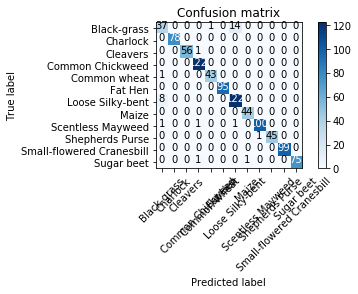

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, final_predictions)

plot_confusion_matrix(cm, data.classes)

### 3.4. Making ensemble predictions (test data)

In [73]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_3 = ConvLearner.pretrained(arch, data, precompute=False)
learn_3.unfreeze()
learn_3.load('after_cycle_3')

In [74]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_4 = ConvLearner.pretrained(arch, data, precompute=False)
learn_4.unfreeze()
learn_4.load('after_cycle_4')

In [75]:
tfms = tfms_from_model(resnet34, size, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn_4 = ConvLearner.pretrained(arch, data, precompute=False)
learn_4.unfreeze()
learn_4.load('after_cycle_4')

In [76]:
test_log_predictions, y = learn.TTA(is_test=True)
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_3 = test_predictions

In [77]:
test_log_predictions, y = learn.TTA(is_test=True)
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_4 = test_predictions

In [78]:
test_log_predictions, y = learn.TTA(is_test=True)
test_predictions = np.argmax(test_log_predictions, axis=1)
test_predictions_classes = [data.classes[pred] for pred in test_predictions]
predictions_5 = test_predictions

In [79]:
final_predictions = []
for prediction_3, prediction_4, prediction_5 in zip(predictions_3, predictions_4, predictions_5):
    current_predictions = [prediction_3, prediction_4, prediction_5]
    if len(set(current_predictions)) == 3:
        pred = prediction_5
    else:
        pred = max(set(current_predictions), key=current_predictions.count)
        
    final_predictions.append(pred)

final_predictions_classes = [data.classes[pred] for pred in final_predictions]

In [80]:
test_file_names = learn.data.test_ds.fnames

with open('submission.csv', 'w') as the_file:
    the_file.write('file,species\n')
    for file_path, prediction in zip(test_file_names, final_predictions_classes):
        file_name = file_path.split('/')[-1]
        the_file.write(file_name)
        the_file.write(",")
        the_file.write(prediction)
        the_file.write("\n")
the_file.close()

from IPython.display import FileLink
FileLink('submission.csv')


/home/paperspace/kaggle_plant_seedlings/submission.csv

After submitting this results to the competition I scored 0.96095, which is slightly better than my first submission, but worse than all others. 